In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
%cd drive/MyDrive/genrecog/
%pip install speechbrain
%pip install torchlibrosa

In [3]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.CNN import Conv1d
from genrecog.tools.trainer import FbankTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader
from importlib import reload
import matplotlib.pyplot as plt

import speechbrain as sb



In [4]:
# Load dataset

train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=400)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=400)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=400)

In [6]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=40, time_sequence=702, hidden_size=128, num_layers=5, output_dim=10):
    super(RNN, self).__init__()

    self.batch_norm_input = torch.nn.BatchNorm1d(time_sequence)

    self.rnn = torch.nn.RNN(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers,
        batch_first=True,
        bias=True
        )
    
    self.batch_norm_hidden = torch.nn.BatchNorm1d(hidden_size)
    self.linear = torch.nn.Linear(hidden_size,output_dim)

  def forward(self, X, hidden=None, use_mean=False):
    X = self.batch_norm_input(X)
    Z, hidden = self.rnn(X, hidden)
    self.Z =Z
    if use_mean:
      z = torch.mean(self.Z, 1)
    else:
      z =  self.Z[:, -1, :]
    z = self.batch_norm_hidden(z)
    out = self.linear(z)
    return out



In [7]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = RNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

RNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
# from genrecog.preprocess.feature import Feature
# import numpy as np

# # feature extractor module
# feature_maker = Feature()


# X_validation, y_validation = next(iter(validation_dataloader))
# X_validation_features = feature_maker.torch_fbank_features(X_validation)
# train_losses = []
# validation_losses = []

# for epoch in range(100):
#     model.train()
#     epoch_losses = []
#     for X_train, y_train in train_dataloader:
#         model.zero_grad()
#         X_features = feature_maker.torch_fbank_features(X_train)
#         y_hat = model(X_features)
#         l = loss(y_hat, y_train)
#         l.backward()
#         optimizer.step()
#         epoch_losses.append(l.item())
#         # print("Epoch %2d final minibatch had loss %.4f" % (epoch, l.item()))
#     print(epoch, np.average(epoch_losses))
#     train_losses.append(np.average(epoch_losses))
#     y_hat_validation = model(X_validation_features)
#     l_validation = loss(y_hat_validation, y_validation)
#     validation_losses.append(l_validation.item())

# plt.plot(train_losses)
# plt.plot(validation_losses)
# plt.show()

    
    # train_losses.append(sum(epoch_losses) / len(epoch_losses))
    # y_pred, y_eval, validation_loss = self.eval()
    # print("Epoch %2d final minibatch had test loss %.4f" % (epoch, validation_loss))
    # self.validation_losses.append(validation_loss)

In [9]:
# model.eval()
# X, y = next(iter(test_dataloader))
# # print(X.shape)
# X_features = feature_maker.torch_fbank_features(X)
# # X_features = torch.nn.functional.normalize(X_features, dim=0)
# # rnn(X_features).softmax(dim=0)
# y_pred = rnn(X_features)
# # print(y_pred[0])
# y_pred_1 = torch.argmax(y_pred, dim=1)
# y_pred_1

In [10]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_pred_1.cpu(), y.cpu())

In [11]:
# import torchlibrosa as tl
# X, y = next(iter(test_dataloader))


# batch_size = 16
# sample_rate = 22050
# win_length = 702
# hop_length = 512
# n_mels = 128

# spectrogram_extractor = tl.Spectrogram(n_fft=win_length, hop_length=hop_length)
# sp = spectrogram_extractor.forward(X[:10].cpu())   # (batch_size, 1, time_steps, freq_bins)


In [12]:
# sp.shape

In [13]:
# # sb.nnet.RNN.RNN
# net = sb.nnet.RNN.RNN(hidden_size=128, input_shape=X_features.shape)
# out, _ = net(X_features.cpu())
# # out[:,-1,:]
# linear = torch.nn.Linear(128,10)
# out = linear(out[:,-1,:])
# print(out.shape)
# out.argmax(dim=1)

In [14]:
# import torch
# import torchlibrosa as tl


# batch_size = 16
# sample_rate = 22050
# win_length = 2048
# hop_length = 512
# n_mels = 40

# spectrogram_extractor = tl.Spectrogram(n_fft=win_length, hop_length=hop_length)
# sp = spectrogram_extractor.forward(X_train.cpu())
# logmel_extractor = tl.LogmelFilterBank(sr=sample_rate, n_fft=win_length, n_mels=n_mels)
# logmel = logmel_extractor.forward(sp) 

In [15]:
# logmel.squeeze(1).shape
# plt.imshow(logmel.squeeze(1).cpu().transpose(1,2)[0])

In [16]:
# rnn2 = RNN(input_size=40, hidden_size=hidden_size, num_layers=num_layers).to(device)
# from genrecog.preprocess.feature import Feature
# import numpy as np


# spectrogram_extractor = tl.Spectrogram(n_fft=win_length, hop_length=hop_length).cuda()
# logmel_extractor = tl.LogmelFilterBank(sr=sample_rate, n_fft=win_length, n_mels=n_mels).cuda()

# feature_maker = Feature()
# for epoch in range(500):
#     rnn2.train()
#     epoch_losses = []
#     for X_train, y_train in train_dataloader:
#         rnn.zero_grad()
#         sp = spectrogram_extractor.forward(X_train)
#         logmel = logmel_extractor.forward(sp).squeeze(1)
#         y_hat = rnn2(logmel)
#         # print(y_hat.argmax(dim=1))
#         l = loss(y_hat, y_train)
#         l.backward()
#         optimizer.step()
#         epoch_losses.append(l.item())
#         # print("Epoch %2d final minibatch had loss %.4f" % (epoch, l.item()))
#     print(epoch, np.average(epoch_losses))
    

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle

class FbankTrainer():
    def __init__(self, model, optimizer, loss, train_dataloader, validation_dataloader, num_epochs):
      self.model = model
      self.train_dataloader = train_dataloader
      self.num_epochs = num_epochs
      self.optimizer = optimizer
      self.loss = loss
      self.train_losses = []
      self.validation_losses = []
      self.train_accuracies = []
      self.validation_accuracies = []
      self.feature_maker = Feature()
      self.validation_dataloader = validation_dataloader


    def accuracy(self, y_true, y_pred):
        return (torch.sum(y_true == y_pred) / y_pred.shape[0])

  
    def plot_loss(self):
        plt.plot(self.train_losses)
        plt.plot(self.validation_losses)
        plt.legend(['Training loss', 'Validation loss'])
        plt.xlabel('loss')
        plt.ylabel('epoch')
    
    def plot_accuracies(self):
        plt.plot(self.train_accuracies)
        plt.plot(self.validation_accuracies)
        plt.legend(['Training Accuracy', 'Validation Accuracy'])
        plt.xlabel('accuracy %')
        plt.ylabel('epoch')
    
    def plot_confusion_matrix(self, eval_loader):
      y_pred, y_eval, validation_loss, validation_accuracy = self.eval(eval_loader)
      array = confusion_matrix(y_eval.cpu(), y_pred.cpu(), normalize='true')*100
      genres = ['country', 'reggae', 'metal', 'pop', 'classical', 'disco', 'hiphop', 'blues', 'jazz', 'rock']
      df_cm = pd.DataFrame(array, index = genres, columns = genres)
      plt.figure(figsize = (10,7))
      sn.heatmap(df_cm, annot=True, cmap="YlGnBu")

    def classification_report(self, eval_loader):
      y_pred, y_eval, validation_loss, validation_accuracy = self.eval(eval_loader)
      genres = ['country', 'reggae', 'metal', 'pop', 'classical', 'disco', 'hiphop', 'blues', 'jazz', 'rock']
      print(classification_report(y_eval.cpu(), y_pred.cpu(), target_names=genres))

    def save(self, name=""):
      with open(f"./samples/trained_models/FbankTrainer_{name}.pkl", 'wb') as handle:
        pickle.dump(self, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
from genrecog.preprocess.feature import Feature
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


class RNNFbankTrainer(FbankTrainer):

    def train(self):
        for epoch in range(self.num_epochs):
            self.model.train()
            epoch_losses = []
            epoch_accuracies = []
            for X_train, y_train in self.train_dataloader:
                self.model.zero_grad()
                X_features = self.feature_maker.torch_fbank_features(X_train)
                y_hat = self.model(X_features)
                l = self.loss(y_hat, y_train)
                l.backward()
                self.optimizer.step()
                epoch_losses.append(l.item())
                epoch_accuracies.append(self.accuracy(y_train, torch.argmax(y_hat, dim=1)).item())
            
            training_loss = sum(epoch_losses) / len(epoch_losses)
            training_accuracy = sum(epoch_accuracies) / len(epoch_accuracies)
            self.train_accuracies.append(training_accuracy)
            self.train_losses.append(training_loss)
            y_pred, y_eval, validation_loss, validation_accuracy = self.eval()
            self.validation_losses.append(validation_loss)
            self.validation_accuracies.append(validation_accuracy)
            print(f"============================== EPOCH {epoch+1} =================================")
            print("Training accuracy %.2f" % (training_accuracy * 100))
            print("Training loss %.4f" % training_loss)
            print("Validation accuracy %.2f" % (validation_accuracy * 100))
            print("Validation loss %.4f" % validation_loss)

    def eval(self, eval_loader=None):
        self.model.eval()
        if eval_loader is None:
          X_val, y_val = next(iter(self.validation_dataloader))
        else:
          X_val, y_val = next(iter(eval_loader))
        with torch.no_grad():
            X_features = self.feature_maker.torch_fbank_features(X_val)
            y_pred = torch.argmax(self.model(X_features), dim=1)
            l = self.loss(self.model(X_features), y_val)
            accuracy = self.accuracy(y_val, y_pred)
        return y_pred, y_val, l.item(), accuracy.item()




In [19]:
trainer = RNNFbankTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, 40)
trainer.train()

============================== EPOCH 1 =================================
Training accuracy 29.22
Training loss 1.9767
Validation accuracy 14.50
Validation loss 2.2626
============================== EPOCH 2 =================================
Training accuracy 37.19
Training loss 1.7774
Validation accuracy 22.00
Validation loss 2.0970
============================== EPOCH 3 =================================
Training accuracy 39.84
Training loss 1.7038
Validation accuracy 29.50
Validation loss 1.9042
============================== EPOCH 4 =================================
Training accuracy 41.00
Training loss 1.6555
Validation accuracy 36.75
Validation loss 1.7572
============================== EPOCH 5 =================================
Training accuracy 42.72
Training loss 1.6197
Validation accuracy 34.00
Validation loss 1.7019
============================== EPOCH 6 =================================
Training accuracy 44.47
Training loss 1.5732
Validation accuracy 39.75
Validation loss 1.648

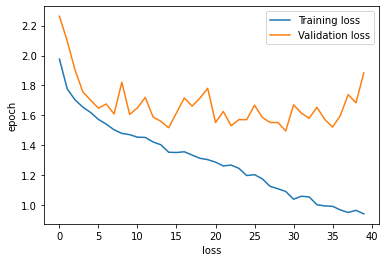

In [20]:
trainer.plot_loss()

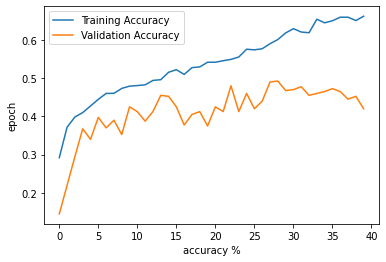

In [21]:
trainer.plot_accuracies()

In [22]:
class LSTM(torch.nn.Module):
  def __init__(self, input_size=40, time_sequence=702, hidden_size=128, num_layers=5, output_dim=10, use_mean=False):
    super(LSTM, self).__init__()

    self.batch_norm_input = torch.nn.BatchNorm1d(time_sequence)

    self.lstm = torch.nn.LSTM(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers,
        batch_first=True,
        bias=True
        )
    
    self.batch_norm_hidden = torch.nn.BatchNorm1d(hidden_size)
    self.linear = torch.nn.Linear(hidden_size,output_dim)
    self.use_mean = use_mean

  def forward(self, X, hidden=None):
    X = self.batch_norm_input(X)
    Z, hidden = self.lstm(X, hidden)
    self.Z =Z
    if self.use_mean:
      z = torch.mean(self.Z, 1)
    else:
      z =  self.Z[:, -1, :]
    z = self.batch_norm_hidden(z)
    out = self.linear(z)
    return out

In [23]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = LSTM(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True

    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

LSTM(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
lstm_trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=40)
lstm_trainer.train()

============================== EPOCH 1 =================================
Training accuracy 28.84
Training loss 1.9245
Validation accuracy 11.25
Validation loss 2.2937
============================== EPOCH 2 =================================
Training accuracy 42.09
Training loss 1.6028
Validation accuracy 23.00
Validation loss 2.2491
============================== EPOCH 3 =================================
Training accuracy 47.56
Training loss 1.4767
Validation accuracy 40.25
Validation loss 2.1740
============================== EPOCH 4 =================================
Training accuracy 50.97
Training loss 1.3781
Validation accuracy 46.75
Validation loss 2.1127
============================== EPOCH 5 =================================
Training accuracy 53.97
Training loss 1.2981
Validation accuracy 51.75
Validation loss 1.9778
============================== EPOCH 6 =================================
Training accuracy 57.19
Training loss 1.2220
Validation accuracy 54.00
Validation loss 1.792

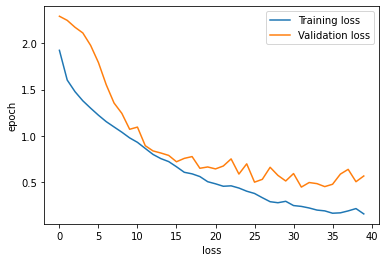

In [ ]:
lstm_trainer.plot_loss()

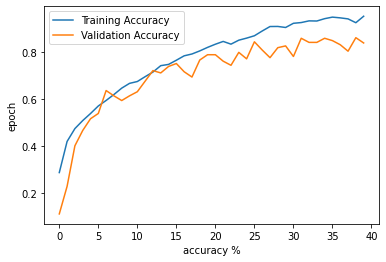

In [ ]:
lstm_trainer.plot_accuracies()

In [ ]:
# y_pred, y_val, loss, accuracy =
# lstm_trainer.accuracy()

lstm_trainer.eval(test_dataloader)

(tensor([6, 2, 7, 2, 6, 4, 5, 4, 6, 5, 6, 1, 3, 9, 6, 3, 9, 1, 1, 7, 8, 8, 8, 4,
         6, 8, 1, 4, 9, 4, 2, 3, 9, 6, 5, 0, 5, 0, 8, 4, 7, 1, 1, 9, 3, 7, 1, 1,
         4, 4, 5, 5, 2, 4, 3, 1, 8, 5, 3, 3, 8, 8, 4, 8, 1, 8, 8, 4, 1, 7, 3, 1,
         4, 1, 2, 6, 0, 3, 9, 4, 5, 0, 0, 9, 9, 9, 2, 0, 7, 4, 2, 5, 5, 4, 0, 9,
         9, 2, 9, 9, 0, 2, 8, 8, 7, 0, 0, 6, 6, 2, 4, 0, 1, 7, 0, 6, 9, 3, 5, 4,
         0, 7, 8, 1, 3, 5, 8, 2, 5, 3, 6, 7, 2, 3, 6, 1, 3, 7, 4, 2, 0, 1, 1, 4,
         0, 4, 0, 6, 2, 3, 2, 2, 8, 1, 5, 4, 3, 0, 9, 9, 5, 4, 8, 9, 7, 6, 0, 4,
         2, 5, 4, 3, 3, 6, 4, 8, 3, 0, 4, 7, 7, 4, 8, 9, 5, 5, 2, 3, 0, 9, 3, 0,
         2, 6, 8, 3, 0, 0, 1, 9, 3, 6, 5, 0, 0, 2, 1, 0, 1, 7, 9, 5, 4, 9, 2, 3,
         1, 8, 4, 2, 3, 8, 7, 0, 9, 2, 0, 1, 6, 1, 4, 0, 5, 5, 0, 8, 5, 2, 1, 0,
         5, 3, 6, 1, 1, 3, 0, 2, 4, 6, 0, 7, 0, 9, 2, 9, 0, 9, 7, 5, 6, 0, 8, 1,
         6, 8, 0, 1, 3, 0, 8, 2, 0, 1, 8, 5, 0, 0, 1, 8, 2, 3, 8, 9, 5, 7, 1, 8,
         0, 8, 7, 8, 6, 5, 3

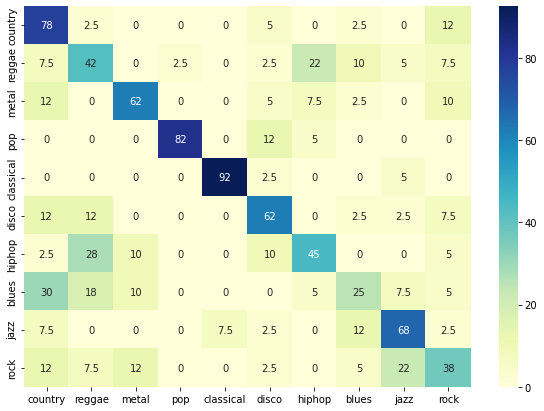

In [ ]:
lstm_trainer.plot_confusion_matrix(test_dataloader)

In [ ]:
lstm_trainer.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.48      0.78      0.59        40
      reggae       0.39      0.42      0.40        40
       metal       0.66      0.62      0.64        40
         pop       0.97      0.82      0.89        40
   classical       0.93      0.93      0.93        40
       disco       0.60      0.62      0.61        40
      hiphop       0.53      0.45      0.49        40
       blues       0.42      0.25      0.31        40
        jazz       0.61      0.68      0.64        40
        rock       0.43      0.38      0.40        40

    accuracy                           0.59       400
   macro avg       0.60      0.59      0.59       400
weighted avg       0.60      0.59      0.59       400



In [ ]:
class GRU(torch.nn.Module):
  def __init__(self, input_size=40, time_sequence=702, hidden_size=128, num_layers=5, output_dim=10, use_mean=False):
    super(GRU, self).__init__()

    self.batch_norm_input = torch.nn.BatchNorm1d(time_sequence)

    self.glu = torch.nn.GRU(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers,
        batch_first=True,
        bias=True
        )
    
    self.batch_norm_hidden = torch.nn.BatchNorm1d(hidden_size)
    self.linear = torch.nn.Linear(hidden_size,output_dim)
    self.use_mean = use_mean

  def forward(self, X, hidden=None):
    X = self.batch_norm_input(X)
    Z, hidden = self.glu(X, hidden)
    self.Z =Z
    if self.use_mean:
      z = torch.mean(self.Z, 1)
    else:
      z =  self.Z[:, -1, :]
    z = self.batch_norm_hidden(z)
    out = self.linear(z)
    return out

In [ ]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = GRU(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=True
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

GRU(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glu): GRU(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
gru_trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=40)
gru_trainer.train()

============================== EPOCH 1 =================================
Training accuracy 32.66
Training loss 1.8266
Validation accuracy 11.75
Validation loss 2.2642
============================== EPOCH 2 =================================
Training accuracy 45.25
Training loss 1.5275
Validation accuracy 23.00
Validation loss 2.1259
============================== EPOCH 3 =================================
Training accuracy 51.62
Training loss 1.4018
Validation accuracy 34.25
Validation loss 1.9575
============================== EPOCH 4 =================================
Training accuracy 55.56
Training loss 1.2996
Validation accuracy 42.25
Validation loss 1.7451
============================== EPOCH 5 =================================
Training accuracy 57.91
Training loss 1.2150
Validation accuracy 44.25
Validation loss 1.5637
============================== EPOCH 6 =================================
Training accuracy 61.16
Training loss 1.1305
Validation accuracy 50.50
Validation loss 1.421

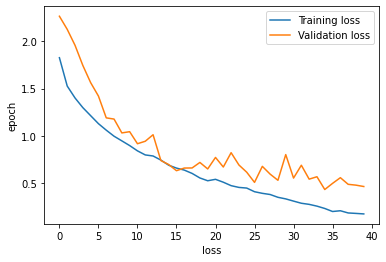

In [ ]:
gru_trainer.plot_loss()

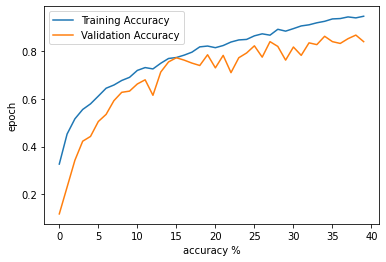

In [ ]:
gru_trainer.plot_accuracies()

In [ ]:
# y_pred, y_val, loss, accuracy =
# lstm_trainer.accuracy()

gru_trainer.eval(test_dataloader)

(tensor([4, 7, 4, 4, 8, 0, 8, 7, 4, 5, 5, 4, 5, 4, 4, 0, 9, 4, 3, 2, 4, 6, 0, 7,
         3, 1, 1, 7, 5, 0, 3, 0, 4, 5, 5, 8, 6, 5, 9, 6, 7, 2, 8, 8, 8, 5, 2, 7,
         5, 3, 8, 9, 2, 7, 1, 9, 4, 8, 3, 8, 8, 9, 5, 0, 8, 3, 3, 2, 5, 4, 9, 1,
         8, 6, 1, 6, 7, 2, 0, 8, 3, 2, 0, 8, 7, 5, 7, 2, 8, 6, 4, 8, 0, 6, 6, 9,
         6, 7, 0, 7, 2, 7, 7, 2, 2, 6, 0, 7, 8, 4, 9, 3, 2, 4, 5, 2, 0, 0, 7, 3,
         6, 7, 4, 3, 2, 4, 7, 6, 4, 9, 7, 3, 5, 9, 7, 5, 9, 0, 5, 7, 3, 5, 2, 1,
         6, 8, 6, 0, 5, 0, 3, 6, 0, 5, 3, 2, 7, 2, 7, 5, 6, 9, 2, 8, 3, 1, 9, 0,
         5, 5, 7, 4, 7, 2, 6, 8, 7, 2, 6, 6, 7, 7, 6, 6, 4, 7, 8, 8, 8, 3, 9, 2,
         6, 5, 8, 8, 5, 7, 9, 6, 6, 6, 7, 8, 3, 2, 7, 8, 0, 0, 9, 7, 2, 6, 6, 7,
         2, 2, 4, 7, 1, 0, 8, 1, 3, 7, 7, 8, 3, 2, 8, 7, 9, 8, 7, 4, 5, 8, 2, 0,
         1, 6, 2, 7, 9, 2, 3, 7, 9, 8, 3, 0, 0, 7, 5, 3, 3, 7, 5, 6, 3, 7, 7, 3,
         8, 2, 8, 8, 4, 4, 8, 7, 7, 7, 5, 6, 3, 5, 7, 1, 3, 3, 2, 6, 4, 2, 6, 2,
         7, 2, 3, 8, 1, 0, 1

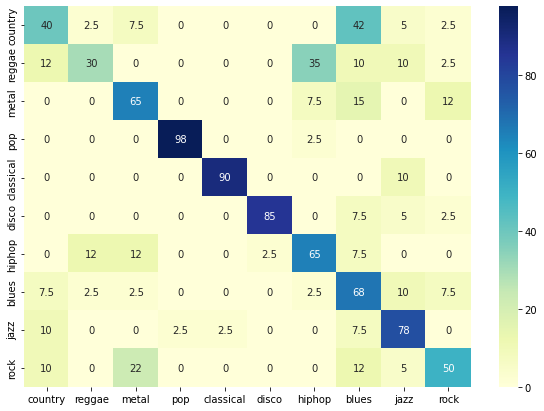

In [ ]:
gru_trainer.plot_confusion_matrix(test_dataloader)

In [ ]:

gru_trainer.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.50      0.40      0.44        40
      reggae       0.63      0.30      0.41        40
       metal       0.59      0.65      0.62        40
         pop       0.97      0.97      0.97        40
   classical       0.97      0.90      0.94        40
       disco       0.97      0.85      0.91        40
      hiphop       0.58      0.65      0.61        40
       blues       0.40      0.68      0.50        40
        jazz       0.63      0.78      0.70        40
        rock       0.65      0.50      0.56        40

    accuracy                           0.67       400
   macro avg       0.69      0.67      0.67       400
weighted avg       0.69      0.67      0.67       400



In [ ]:
gru_trainer.save("GRU_with_mean")

In [ ]:
with open('./samples/trained_models/FbankTrainer_GRU_with_mean.pkl', 'rb') as handle:
    loaded_model = pickle.load(handle)

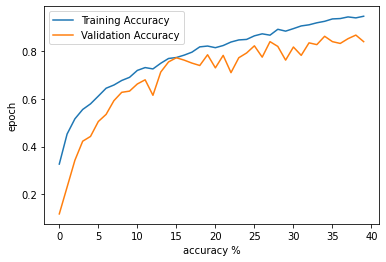

In [ ]:
loaded_model.plot_accuracies()